In [ ]:
pip install captum

     |████████████████████████████████| 1.4 MB 5.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils
from scipy import stats
from tqdm import tqdm
from captum.attr import IntegratedGradients, GuidedGradCam
from matplotlib import pyplot as plt

torch.manual_seed(5001)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(5001) 

In [ ]:
image_height = {5: 32, 20: 64, 60: 96}  
image_width = {5: 15, 20: 60, 60: 180}

year = 2019
images = np.memmap(os.path.join("./drive/MyDrive/5013/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, image_height[20], image_width[20]))
label_df = pd.read_feather(os.path.join("./drive/MyDrive/5013/monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
label_df.head(50)

,Date,StockID,EWMA_vol,Retx,Retx_5d,Retx_20d,Retx_60d,Retx_week,Retx_month,Retx_quarter,...,Ret_week,Ret_month,Ret_quarter,Ret_5d,Ret_20d,Ret_60d,Ret_65d,Ret_180d,Ret_250d,Ret_260d
0,2019-01-31,10026,0.000988,0.025581,0.013346,0.008357,0.006478,NaN,0.006025,NaN,...,NaN,0.006025,NaN,0.013346,0.008357,0.009807,0.068958,0.278010,0.104675,0.122708
1,2019-02-28,10026,0.000424,0.016630,-0.021123,0.026340,0.047011,NaN,0.022926,NaN,...,NaN,0.026309,NaN,-0.021123,0.029734,0.050473,0.032835,0.193290,0.118396,-0.047037
2,2019-03-29,10026,0.000209,-0.003326,-0.024616,-0.021972,0.022539,-0.024616,-0.010451,0.013285,...,-0.024616,-0.010451,0.016394,-0.024616,-0.021972,0.025677,0.025614,0.171499,-0.241804,-0.184602
3,2019-04-30,10026,0.000136,0.011780,0.020867,0.018959,0.027995,NaN,0.023349,NaN,...,NaN,0.023349,NaN,0.020867,0.018959,0.031149,0.156932,0.179088,-0.197087,-0.215797
4,2019-05-31,10026,0.000105,0.002493,0.020018,0.000623,0.188876,0.020018,0.000623,NaN,...,0.020018,0.003693,NaN,0.020018,0.003693,0.192524,0.219214,0.079433,-0.181362,-0.217423
5,2019-06-28,10026,0.000118,0.002679,0.014726,0.013980,0.189937,0.017707,0.154645,0.192919,...,0.017707,0.154645,0.196024,0.014726,0.013980,0.193034,0.179392,-0.248318,-0.232352,-0.231342
6,2019-07-31,10026,0.000963,0.003889,-0.005218,0.017329,0.022923,NaN,0.038852,NaN,...,NaN,0.038852,NaN,-0.005218,0.017329,0.025586,0.029146,-0.305147,-0.311503,-0.284125
7,2019-08-30,10026,0.000440,0.009622,0.001864,-0.005491,-0.032840,0.001657,-0.005491,NaN,...,0.001657,-0.002902,NaN,0.001864,-0.002902,-0.030323,-0.029181,-0.355693,-0.285280,-0.291697
8,2019-09-30,10026,0.000227,0.003135,0.002500,-0.007189,-0.033285,NaN,-0.006460,-0.040264,...,NaN,-0.006460,-0.037272,0.002500,-0.007189,-0.030271,-0.050804,-0.314221,-0.320023,-0.293550
9,2019-10-31,10026,0.000115,-0.007699,-0.000943,-0.030195,-0.116904,NaN,-0.030195,NaN,...,NaN,-0.030195,NaN,-0.000943,-0.030195,-0.114151,-0.121355,-0.321709,-0.293811,-0.161810


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
model.load_state_dict(torch.load("./drive/MyDrive/5013/CNN_baseline.pth.tar"))
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPoo

In [ ]:
x = torch.Tensor(images[16].copy())
x = x.reshape(-1,1,64,60)
x.requires_grad = True
baseline = torch.zeros_like(x)

In [ ]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(x.to(device), baseline.to(device), target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[[[ 0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0000, -0.0000,  ..., -0.0160,  0.0359,  0.1003],
          ...,
          [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0052,  0.0000,  ..., -0.0000, -0.0671,  0.0000]]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
Convergence Delta: tensor([-0.0010], device='cuda:0', dtype=torch.float64)


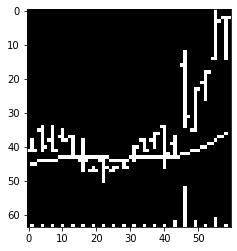

In [ ]:
plt.imshow(x[0,0].detach().cpu().numpy(),cmap="bone")

In [ ]:
cam_layer_1 = GuidedGradCam(model, model.layer1)
attributions_layer_1 = cam_layer_1.attribute(x.to(device), target=1)
cam_layer_2 = GuidedGradCam(model, model.layer2)
attributions_layer_2 = cam_layer_2.attribute(x.to(device), target=1)
cam_layer_3 = GuidedGradCam(model, model.layer3)
attributions_layer_3 = cam_layer_3.attribute(x.to(device), target=1)

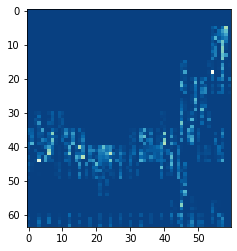

In [ ]:
plt.imshow(abs(attributions_layer_1.detach().cpu().numpy()[0,0]), cmap="GnBu_r")

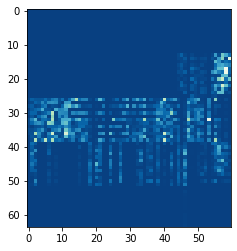

In [ ]:
plt.imshow(abs(attributions_layer_2.detach().cpu().numpy()[0,0]), cmap="GnBu_r")

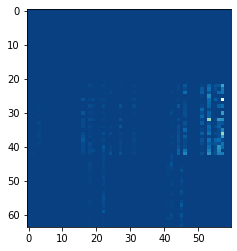

In [ ]:
plt.imshow(abs(attributions_layer_3.detach().cpu().numpy()[0,0]), cmap="GnBu_r")

In [ ]:
x = torch.Tensor(images[18].copy())
x = x.reshape(-1,1,64,60)
x.requires_grad = True
baseline = torch.zeros_like(x)

In [ ]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(x.to(device), baseline.to(device), target=0, return_convergence_delta=True)
print('IG Attributions:', attributions)
print('Convergence Delta:', delta)

IG Attributions: tensor([[[[ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0013, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0000, -0.0021, -0.0017,  ...,  0.0000, -0.0000, -0.0000],
          ...,
          [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0295, -0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0465, -0.0000],
          [ 0.0000, -0.0113, -0.0000,  ...,  0.0000, -0.0262, -0.0000]]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)
Convergence Delta: tensor([0.0032], device='cuda:0', dtype=torch.float64)


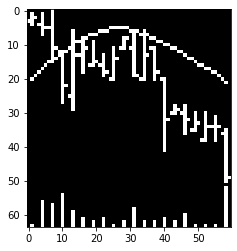

In [ ]:
plt.imshow(x[0,0].detach().cpu().numpy(),cmap="bone")

In [ ]:
cam_layer_1 = GuidedGradCam(model, model.layer1)
attributions_layer_1 = cam_layer_1.attribute(x.to(device), target=1)
cam_layer_2 = GuidedGradCam(model, model.layer2)
attributions_layer_2 = cam_layer_2.attribute(x.to(device), target=1)
cam_layer_3 = GuidedGradCam(model, model.layer3)
attributions_layer_3 = cam_layer_3.attribute(x.to(device), target=1)

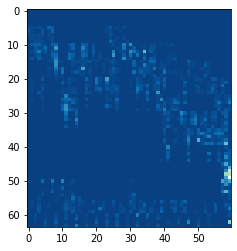

In [ ]:
plt.imshow(abs(attributions_layer_1.detach().cpu().numpy()[0,0]), cmap="GnBu_r")

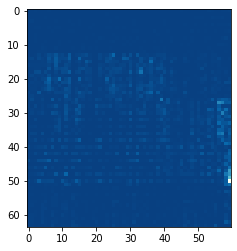

In [ ]:
plt.imshow(abs(attributions_layer_2.detach().cpu().numpy()[0,0]), cmap="GnBu_r")

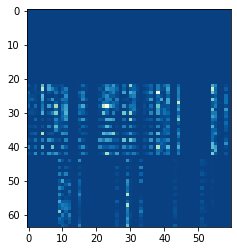

In [ ]:
plt.imshow(abs(attributions_layer_3.detach().cpu().numpy()[0,0]), cmap="GnBu_r")